In [ ]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as pl
import plotly.express as px
import datetime
import optuna
import warnings
import itertools

warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.metrics import r2_score

In [3]:
def preprocess_triplets(res_df, date_df, triplets_columns="triplets", date_column="timestamp"):
  triplets = res_df[triplets_columns].values.tolist()
  dates = date_df[date_column].values.tolist()
  all_triplets = []
  for i, label in enumerate(triplets):
      all_triplets.extend([list(item) + [dates[i]] for item in eval(label)])

  data = []
  for triplet in all_triplets:
      at, ot, sp, ts = triplet
      at = at.lower()
      ot = ot.lower()
      data.append([ts, at, ot, sp, (at, ot, sp), (at, ot)])
  data = pd.DataFrame(data)
  data.columns = ['date', 'aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion']

  data["timestamp"] = data["date"].apply(lambda x: datetime.datetime.fromisoformat(x).timestamp())

  return data

In [4]:
reviews = pd.read_csv("./data/results_triplets_sravni.csv")
time = pd.read_csv("./data/reviews_sravni.csv")

In [5]:
result = preprocess_triplets(reviews, time, "pred_text", "date")

In [10]:
result.groupby("aspect").size().sort_values(ascending=False)[5:15]

aspect
карта         176
сотрудники    172
банку         164
решение       152
менеджеру     143
отношение     128
работа        117
кэшбэк        110
сервис        102
сотруднику    101
dtype: int64

In [7]:
# сюда вставить аспект

def aspect_sentiment_bytime(data, aspect):
  aspect_data = data.groupby("aspect").get_group(aspect).sort_values("timestamp")

  def count_pos_neg(group):
    sent_dict = {"count_pos" : 0, "count_neg" : 0}
    for item in group:
      if item == "POS": sent_dict["count_pos"] += 1
      else: sent_dict["count_neg"] += 1
    return sent_dict
  counted_sentiment = aspect_data.groupby("date")[["sentiment"]].agg(count_pos_neg).reset_index(names=["date"])

  count_pos = 1; count_neg = 1;
  ratio = []
  for i, item in counted_sentiment.iterrows():
    count_pos += item["sentiment"]["count_pos"]
    count_neg += item["sentiment"]["count_neg"]
    ratio.append(100 * count_pos / (count_neg + count_pos))

  smoothing_k = 1
  data_ratio = counted_sentiment[["date"]].iloc[::smoothing_k]
  data_ratio["Доля положительных"] = ratio[::smoothing_k]


  fig = px.line(data_ratio, x="date", y="Доля положительных")
  fig.update_yaxes(range=[min(ratio)-1, max(ratio)+1], autorange=False)
  fig.update_layout(
    title=f'Зависимость доли положительных триплетов, Аспект - "{aspect}"',
    xaxis_title='Дата',
    yaxis_title='Доля положительных триплетов',
    )
  # fig.update_layout(scattermode="group")
  fig.show()
    
  return pd.concat([pd.Series(sorted(aspect_data["timestamp"].unique())), data_ratio["Доля положительных"].reset_index(drop=True)], axis=1)

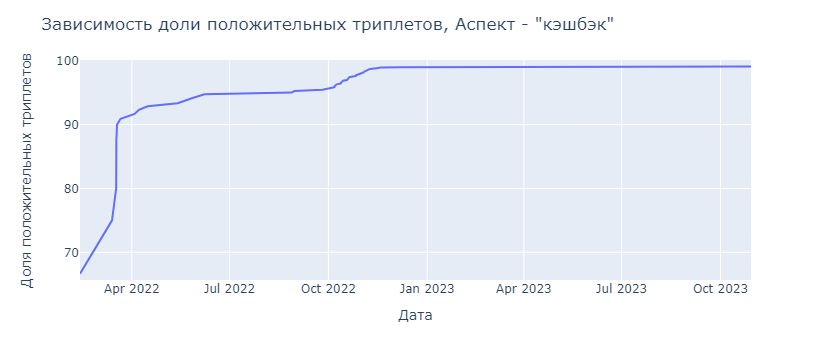

In [12]:
ts_data = aspect_sentiment_bytime(result, "кэшбэк")

In [77]:
X = ts_data["Доля положительных"].values
train, test = X[:int(0.9 * len(X))], X[int(0.9 * len(X)):]

In [ ]:
d = range(0, 3)
p = q = range(3, 13)
pdq = list(itertools.product(p, d, q))
s = [8]
pdqs = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

def objective_sarima(trial):
    order=trial.suggest_categorical('order', pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
    print("parameters selected")
    try:
      model = SARIMAX(train, order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
      mdl = model.fit(disp=0)
      print("model trained, starting forecasting...")
      predictions = mdl.forecast(len(test))
      print("forecating done!")
      predictions = np.array(predictions).reshape(-1, 1)
      # mape = mean_absolute_percentage_error(test, predictions)
      r2 = r2_score(test, predictions)
      # accuracy = (r2 + (1- mape)) / 2
      # print(mape, r2)
      return r2
    except:
      print("incorrect params")
      return -100
study=optuna.create_study(direction="maximize")
study.optimize(objective_sarima, n_trials=50, show_progress_bar=True)

In [86]:
best_params = study.best_trial.params

In [93]:
model=SARIMAX(train,  order= best_params["order"], seasonal_order= best_params["seasonal_order"], trend= best_params["trend"], initialization='approximate_diffuse')
mdl = model.fit(disp=0)
print("model trained, starting forecasting...")
predictions = mdl.forecast(10)
print("forecating done!")
# predictions = np.array(predictions)

model trained, starting forecasting...
forecating done!


In [127]:
def plot_arimo_results(best_params, ts_data, aspect, num=10):
    model=SARIMAX(train,  order= best_params["order"], seasonal_order= best_params["seasonal_order"], trend= best_params["trend"], initialization='approximate_diffuse')
    mdl = model.fit(disp=0)
    print("model trained, starting forecasting...")
    predictions = mdl.forecast(num)
    print("forecating done!")
    diff_mean = np.diff(ts_data[0]).mean()
    def gen_ts(start, diff_mean, num):
        result = [start]
        for i in range(num): result.append(result[-1] + diff_mean)
        return result[1:]
    next_ts = gen_ts(ts_data.iloc[len(ts_data) - 1, 0],  diff_mean, num)
    ratios = X.tolist() + list(predictions)
    fig = px.line(y=ratios, x=[datetime.datetime.fromtimestamp(i).__str__() for i in ts_data[0].tolist()+next_ts])
    fig.update_yaxes(range=[min(ratios)-1, max(ratios)+1], autorange=False)
    fig.update_layout(
        title=f'Аспект - "{aspect}", предсказания на {int(diff_mean // 3600 // 24 * num)} дней вперёд',
        xaxis_title='Дата',
        yaxis_title='Доля положительных триплетов',
    )
    # fig.update_layout(scattermode="group")
    fig.show()

model trained, starting forecasting...
forecating done!


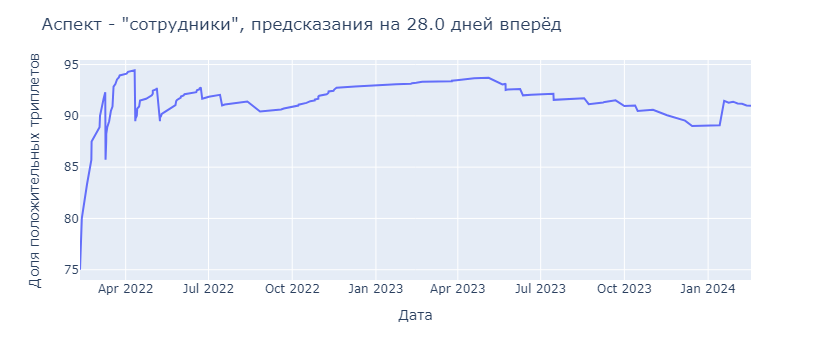

In [128]:
plot_arimo_results(best_params, ts_data, "сотрудники", 7)